In [7]:
# %pip install scipy
# %pip install seaborn
# %pip install scikit-learn
%pip install keras-focal-loss

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement keras-focal-loss (from versions: none)
ERROR: No matching distribution found for keras-focal-loss
You should consider upgrading via the 'd:\python\python.exe -m pip install --upgrade pip' command.


In [54]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,GlobalAveragePooling2D
import cv2 
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from sklearn.utils import resample

In [29]:
data_path=r'D:\\skin_disease_data\\train'

In [55]:
data=[]
for label  in os.listdir(data_path):
    for img in os.listdir(os.path.join(data_path,label)):
        data.append((os.path.join(data_path,label,img),label))
df = pd.DataFrame(data, columns=["filepath", "label"])
max_count = df['label'].value_counts().max()
balanced_df = pd.concat([
    resample(df[df['label'] == cls],
             replace=True,
             n_samples=max_count,
             random_state=42)
    for cls in df['label'].unique()
])
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [56]:
splitter=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
train_idx,val_idx=next(splitter.split(df["filepath"],df["label"]))
train_df=df.iloc[train_idx].reset_index(drop=True)
val_df=df.iloc[val_idx].reset_index(drop=True)

In [57]:
datagen=ImageDataGenerator(
    rescale=1./255,##normalise pixel to 0,1
    # validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.8,1.2]
)

In [58]:
train_gen=datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
    )

val_gen=datagen.flow_from_dataframe(
   val_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False   
)

Found 12520 validated image filenames belonging to 25 classes.
Found 3130 validated image filenames belonging to 25 classes.


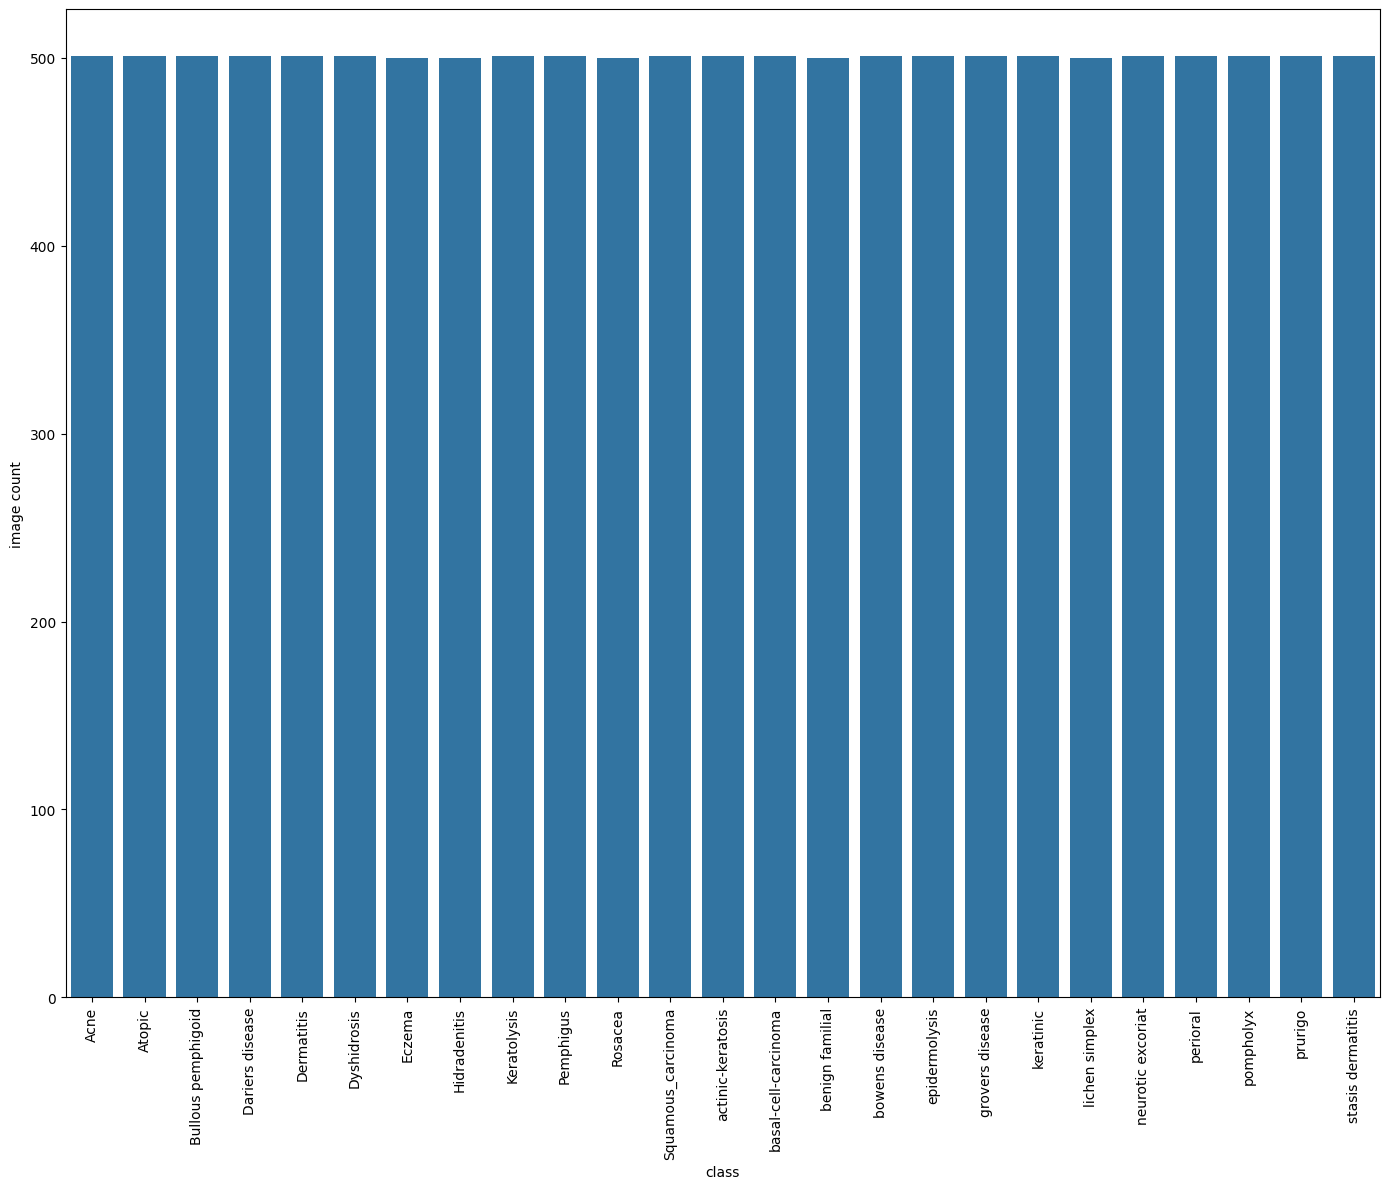

In [59]:
label=train_gen.classes
class_names=list(train_gen.class_indices.keys())

plt.figure(figsize=(14,12))
sns.countplot(x=label)
plt.xticks(ticks=np.arange(len(class_names)),labels=class_names,rotation=90)
plt.xlabel('class')
plt.ylabel('image count')
plt.tight_layout()
plt.show()


In [60]:
class_weight=compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label),
    y=label
)
class_weight_dict=dict(enumerate(class_weight))
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [61]:
base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model.trainable=False

In [62]:

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.4)(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.3)(x)
num_classes = len(train_gen.class_indices)
prediction=Dense(num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

model.compile(
    optimizer='adam',
loss=focal_loss(gamma=2.0,alpha=0.25),
metrics=['accuracy'])

In [63]:
early_stop=EarlyStopping(monitor='val_loss',
                         patience=5,
                         restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [64]:
history=model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop,reduce_lr],
    class_weight=class_weight_dict
)

d:\python\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.1916 - loss: 0.6345 - val_accuracy: 0.4780 - val_loss: 0.3351 - learning_rate: 0.0010
Epoch 2/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.4210 - loss: 0.3815 - val_accuracy: 0.6096 - val_loss: 0.2425 - learning_rate: 0.0010
Epoch 3/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.4986 - loss: 0.3095 - val_accuracy: 0.6508 - val_loss: 0.2055 - learning_rate: 0.0010
Epoch 4/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 644s 2s/step - accuracy: 0.5388 - loss: 0.2748 - val_accuracy: 0.6958 - val_loss: 0.1817 - learning_rate: 0.0010
Epoch 5/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 709s 2s/step - accuracy: 0.5685 - loss: 0.2510 - val_accuracy: 0.7042 - val_loss: 0.1685 - learning_rate: 0.0010
Epoch 6/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - accuracy: 0.5908 - loss: 0.2304 - val_accuracy: 0.7441 - val_loss: 0.1440 - learning_rate: 0.0010
Epoch 7/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.6033 - loss: 0.

In [65]:
for layer in base_model.layers[-40:]:
    layer.trainable=True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [66]:
history=model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop,reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.2504 - loss: 2.9790 - val_accuracy: 0.6965 - val_loss: 1.0260 - learning_rate: 1.0000e-05
Epoch 2/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.4499 - loss: 1.7946 - val_accuracy: 0.6939 - val_loss: 1.0253 - learning_rate: 1.0000e-05
Epoch 3/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 710s 2s/step - accuracy: 0.5254 - loss: 1.5264 - val_accuracy: 0.7131 - val_loss: 0.9693 - learning_rate: 1.0000e-05
Epoch 4/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.5810 - loss: 1.3479 - val_accuracy: 0.7403 - val_loss: 0.8817 - learning_rate: 1.0000e-05
Epoch 5/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - accuracy: 0.6179 - loss: 1.2379 - val_accuracy: 0.7534 - val_loss: 0.8212 - learning_rate: 1.0000e-05
Epoch 6/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.6438 - loss: 1.1073 - val_accuracy: 0.7594 - val_loss: 0.7789 - learning_rate: 1.0000e-05
Epoch 7/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - acc

In [68]:
y_pred=model.predict(val_gen)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(val_gen.classes,y_pred))
# sns.heatmap(confusion_matrix(val_gen.classes,y_pred),annot=True)

98/98 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       125
           1       0.80      0.78      0.79       125
           2       0.97      0.89      0.93       125
           3       0.86      0.90      0.88       125
           4       0.82      0.82      0.82       125
           5       0.95      0.98      0.96       125
           6       0.84      0.34      0.49       126
           7       0.94      0.94      0.94       126
           8       0.89      1.00      0.94       125
           9       0.91      0.94      0.93       125
          10       0.83      0.83      0.83       126
          11       0.84      0.74      0.79       125
          12       0.79      0.66      0.72       125
          13       0.75      0.63      0.69       125
          14       0.95      1.00      0.98       126
          15       0.85      0.89      0.87       125
          16       0.95      0.98      0.

In [70]:
model.save('skin_model.keras')
model=tf.keras.models.load_model('skin_model.keras')
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

d:\python\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 92 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmplx5nhjcw\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmplx5nhjcw\assets


Saved artifact at 'C:\Users\HP\AppData\Local\Temp\tmplx5nhjcw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 25), dtype=tf.float32, name=None)
Captures:
  2395618975360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618998080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618993856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618970256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618999312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618991744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618985232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618984528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618989456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2395618985408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  239561

In [1]:
with open('skin_model.tflite','wb') as f:
    f.write(tflite_model)

NameError: name 'tflite_model' is not defined